In [1]:
from collections import defaultdict
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import *
from gym_minigrid.wrappers import *
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
from scipy.special import softmax
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import vizdoom as vzd
import vizdoomgym


from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.models.dqn.dsr.tcf_model import TCFModel
from rlpyt.models.dqn.dsr.grid_dsr_model import GridDsrModel
from rlpyt.envs.gym import *
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.buffer import buffer_to, torchify_buffer
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

### Key-Based Environments

In [89]:
# env = gym.make(id='MiniGrid-DoorKey-8x8-v0')
env = gym.make(id='MiniGrid-KeyCorridorS4R3-v0')
# env.reset()

In [82]:
env.connect_all()

[]

In [83]:
env.get_room(1, 1).door_pos

[(6, 5), (5, 6), (3, 5), (4, 3)]

In [84]:
env.agent_pos

array([5, 3])

In [114]:
env.room_from_pos(1, 1).top

(0, 0)

In [117]:
def test(a, b):
    print(a, b)

In [119]:
arr = np.array([1, 2])
test(*arr)

1 2


In [124]:
env.room_from_pos

<bound method RoomGrid.room_from_pos of <gym_minigrid.envs.keycorridor.KeyCorridorS4R3 object at 0x7ff7e865f150>>

In [132]:
env.room_from_pos(1, 1).doors

[<gym_minigrid.minigrid.Door at 0x7ff7e86783d0>, None, None, None]

In [116]:
x

1

In [ ]:
env.room_from_pos(1, 1).

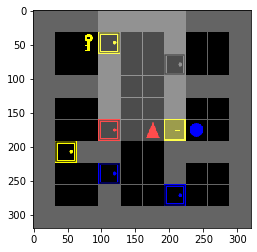

In [140]:
plt.imshow(env.render(8))

In [161]:
env.room_grid[1][1].doors

 True,
 True]

In [141]:
env.agent_pos

array([5, 5])

In [151]:
def clear_env(env):
    for i in range(env.grid.width):
        for j in range(env.grid.height):
            obj = env.grid.get(i, j)
            if isinstance(obj, Key):
                key_pos = (i, j)
            if isinstance(obj, Ball):
                ball_pos = (i, j)

    start_room = env.room_from_pos(*env.agent_pos)
    start_room_tops = set([start_room.top] + [])
    print(start_room_top)

    doors_to_key = []
    key_room = env.room_from_pos(*key_pos)
    rooms_stack = [key_room]
    visited_rooms = set()
    while rooms_stack:
        current_room = rooms_stack.pop()
        print(current_room.top)
        visited_rooms.add(current_room.top)
        if current_room.top == start_room_top:
            break

        dead_end = True
        for i, doors in enumerate(current_room.doors):
            if doors is not None and current_room.neighbors[i].top not in visited_rooms:
                dead_end = False
                doors_to_key.append(current_room.door_pos[i])
                rooms_stack.append(current_room.neighbors[i])

        if dead_end:
            doors_to_key.pop()
    return doors_to_key

In [152]:
clear_env(env)

(3, 3)
(0, 0)
(3, 0)
(3, 3)


[(3, 1), (6, 2), (4, 3)]

In [4]:
env.max_steps

270

In [ ]:
env.place_agent()

In [ ]:
env.grid.get(2, 1).

In [ ]:
for i in range(env.grid.height):
    for j in range(env.grid.width):
        print(i, j, env.grid.get(i, j), isinstance(env.grid.get(i,j), Wall))

In [ ]:
env.unwrapped.agent_dir = 1

In [ ]:
plt.imshow(env.render(8))

In [ ]:
result = env.step(6)

In [ ]:
result

In [ ]:
env.unwrapped.action_space

In [ ]:
env.carrying

In [78]:
with open('../experiments/configs/door-key.json') as f:
    config = json.load(f)

mode = config['mode']
mode = 'doorkey'
minigrid_config = config['env']
minigrid_config['start_pos'] = [4, 5]
env_id='MiniGrid-KeyCorridorS4R3-v0'
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


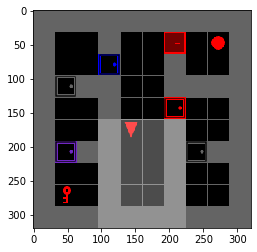

In [80]:
plt.imshow(env.render(8))

In [11]:
obs = env.get_goal_state()

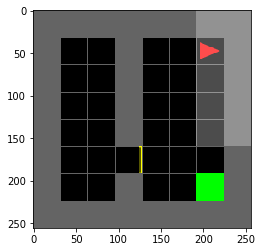

In [12]:
plt.imshow(env.render(8))

### Landmarks Exploration

In [21]:
with open('../experiments/configs/tcf-doors-start.json') as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['env']
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


In [26]:
test_env = env.env.env

In [34]:
def get_random_start(env):
    room = env.rooms[np.random.randint(len(env.rooms))]
    return env.place_agent(room.top, room.size)

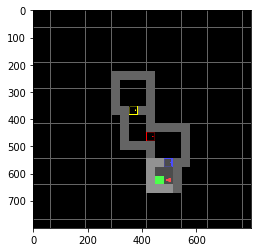

In [47]:
obs = test_env.reset()
test_env.unwrapped.agent_pos = get_random_start(test_env)
plt.imshow(test_env.render(4))

In [38]:
test_env.unwrapped.agent_pos

array([15, 19])

In [39]:
test_env.grid.encode()[15, 19]

array([1, 0, 0], dtype=uint8)

In [ ]:
# env.step(0)
env.step(1)
# env.step(2)
plt.imshow(env.render(4))

In [ ]:
env.step(4)
plt.imshow(env.render(4))

In [ ]:
env.steps

In [ ]:
env.rooms[0].exitDoorPos

In [ ]:
start_obs = env.reset()

In [ ]:
obs = start_obs

In [ ]:
set(tuple(door[1:]) for door in obs[obs[:, :, 0] == 4])


In [ ]:
start_obs.shape

In [ ]:
plt.imshow(env.render(1))

In [ ]:
env.agent_pos

In [ ]:
env.goal_pos

In [ ]:
start_obs[5, 17, 0] = 1

In [ ]:
grid, _ = Grid.decode(start_obs)

In [ ]:
img = grid.render(8, agent_pos=(5, 17), agent_dir=env.agent_dir)

In [ ]:
plt.imshow(img)

In [ ]:
device = torch.device('cuda', index=0)
params = torch.load('../data/local/20200701/multiroom/run_38/itr_1999999.pkl')
feature_model = TCFModel(env.observation_space.shape, env.action_space.n, **config['agent']['feature_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['feature_model'])
feature_model.to(device)
dsr_model = GridDsrModel(env.observation_space.shape, env.action_space.n, **config['agent']['model_kwargs']) 
dsr_model.load_state_dict(params['agent_state_dict']['model'])
dsr_model.to(device)

In [ ]:
def visualize(obs, pos):
    plt.figure(figsize=(7, 7))
    viz_obs = obs.copy()
    viz_obs[viz_obs == 10] = 1
    grid, _ = Grid.decode(viz_obs)
    img = grid.render(8, agent_pos=tuple(pos), agent_dir=3)
    plt.imshow(img)

def get_dsr(obs):
    observation = torchify_buffer(obs).unsqueeze(0).float()

    model_inputs = buffer_to(observation,
            device=device)
    features = feature_model(model_inputs, mode='encode')

    model_inputs = buffer_to(features,
            device=device)
    dsr = dsr_model(model_inputs, mode='dsr')
    return dsr

def get_similarity(dsr_a, dsr_b):
    norm_dsr_a = dsr_a.mean(dim=1) / torch.norm(dsr_a.mean(dim=1), p=2, keepdim=True)
    norm_dsr_b = dsr_b.mean(dim=1) / torch.norm(dsr_b.mean(dim=1), p=2, keepdim=True)
    return torch.matmul(norm_dsr_a, norm_dsr_b.T)


In [ ]:
oracle_distance_matrix = env.get_oracle_distance_matrix()
oracle_edge_threshold = 7

def get_oracle_edges(observations, positions):
    num_rooms = len(env.rooms)
    door_pos = env.get_doors()
    num_doors = len(door_pos)

    def get_door_states(obs):
        door_states = []
        for pos in door_pos:
            if obs[pos[0], pos[1], 0] != 4:
                door_states.append(-1)
            else:
                door_states.append(obs[pos[0], pos[1], 2])
        return np.array(door_states, dtype=int)

    # get oracle edges
    N = len(observations)
    oracle_edges = np.zeros((N, N), dtype=bool)

    for i in range(N):
        for j in range(i + 1, N):
            pos_i = positions[i]
            pos_j = positions[j]

            room_i, is_room_i = env.get_room(pos_i)
            room_j, is_room_j = env.get_room(pos_j)

            door_states_i = get_door_states(observations[i])
            door_states_j = get_door_states(observations[j])
            door_states_compared = door_states_i == door_states_j
            num_same_doors = door_states_compared.sum()

            edge_exists = False
            
            if is_room_i and is_room_j:
                if room_i == room_j:
                    if num_same_doors == num_doors:
                        edge_exists = True
                    elif num_same_doors == (num_doors - 1):
                        if room_i == 0:
                            edge_exists = not door_states_compared[room_i]
                        elif room_i == (num_rooms - 1):
                            edge_exists = not door_states_compared[room_i - 1]
                        else:
                            edge_exists = door_states_compared[room_i] ^ door_states_compared[room_i - 1]
                elif abs(room_i - room_j) == 1:
                    distance = oracle_distance_matrix[pos_i[0], pos_i[1], pos_j[0], pos_j[1]]
                    if distance < oracle_edge_threshold and num_same_doors == num_doors:
                        edge_exists = door_states_i[min(room_i, room_j)] == 0
            elif is_room_i ^ is_room_j:
                if num_same_doors == (num_doors - 1):
                    if is_room_i:
                        edge_exists = room_i == room_j | (room_i - 1) == room_j
                    else:
                        edge_exists = room_j == room_i | (room_j - 1) == room_i
            oracle_edges[i, j] = edge_exists
    return oracle_edges

In [ ]:
landmarks = np.load('../data/local/20200705/multiroom/run_53/landmarks_itr_2449999.npz')
observations = landmarks['observations']
positions = landmarks['positions']
successes = landmarks['successes']
attempts = landmarks['attempts']

In [ ]:
attempts[np.triu_indices(18, k=1)].shape

In [ ]:
np.triu_indices(3, k=1)

In [ ]:
attempt_threshold = max(attempts.mean() - attempts.std(), 1)

In [ ]:
attempts.std()

In [ ]:
low_attempt_edges = attempts < attempt_threshold

In [ ]:
N = len(observations)

In [ ]:
oracle_edges = get_oracle_edges(observations, positions)

In [ ]:
edges = np.zeros((N, N, 2), dtype=int)
x, y = np.meshgrid(np.arange(N), np.arange(N))
edges[:, :, 0] = y
edges[:, :, 1] = x

In [ ]:
edges[low_attempt_edges]

In [ ]:
oracle_edges

In [ ]:
edge_success_rate = successes / np.clip(attempts, 1, None)

In [ ]:
edge_success_rate[oracle_edges]

In [ ]:
attempts[oracle_edges]

In [ ]:
edge_success_rate[12, 0]

In [ ]:
edges[oracle_edges]

In [ ]:
for idx in [6, 0]:
    pos = positions[idx]
    obs = observations[idx]
    visualize(observations[idx], positions[idx])

In [ ]:
np.round(attempts[oracle_edges])

In [ ]:
edge_success_rate[oracle_edges & (attempts >= 1)]

In [ ]:
np.average(edge_success_rate[oracle_edges & (attempts >= 1)])

In [ ]:
success_rates[0, 12]

In [ ]:
attempts[0, 12]

In [ ]:
np.round(successes - attempts, 2)

In [ ]:
landmarks['visitations']

In [ ]:
dsr = landmarks['dsr']

In [ ]:
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)

In [ ]:
similarities = np.clip(np.matmul(norm_dsr, norm_dsr.T), a_min=1e-2, a_max=1.0)

In [ ]:
(successes > 0).shape

In [ ]:
np.where(successes > 0, np.round(similarities, 2), np.nan)

In [ ]:
obs = observations[0]

In [ ]:
set(tuple(door[1:]) for door in obs[obs[:, :, 0] == 4])

In [ ]:
idx = 4

In [ ]:
pos = positions[idx]
obs = observations[idx]
visualize(observations[idx], positions[idx])

In [ ]:
agent = observations[idx][pos[0], pos[1]]
agent

In [ ]:
idx = 0

In [ ]:
visualize(observations[idx], positions[idx])

In [ ]:
closed = get_dsr(observations[1])
opened = get_dsr(observations[6])

In [ ]:
get_similarity(closed, opened)

In [ ]:
obs_copy = observations[6].copy()

In [ ]:
obs_copy[11, 9] = [1, 0, 0]
obs_copy[11, 10] = [10, 0, 1]

In [ ]:
opened_closer = get_dsr(obs_copy)

In [ ]:
get_similarity(closed, opened_closer)

In [ ]:
one_opened = get_dsr(observations[7])
two_opened = get_dsr(observations[8])

In [ ]:
get_similarity(one_opened, two_opened)

In [ ]:
idx = 12
obs = landmarks['observations'][idx]
obs = obs.astype('uint8')
pos = landmarks['positions'][idx]
visualize(observations[idx], positions[idx])

In [ ]:
get_similarity(get_dsr(observations[4]), get_dsr(observations[0]))

In [ ]:
obs[pos[0], pos[1]]

In [ ]:
pos

In [ ]:
doors_closed = obs.copy()
doors_closed_dsr = get_dsr(doors_closed)

In [ ]:
first_opened = obs.copy()
first_opened[11, 11, 2] = 0
first_opened[13, 14, 2] = 0
first_opened[15, 17, 2] = 0
# first_opened[14, 18] = [1, 0, 0]
# first_opened[11, 9] = [10, 0, 1]
first_opened[pos[0], pos[1]] = [1, 0, 0]
first_opened[11, 13] = [10, 0, 1]
first_opened_dsr = get_dsr(first_opened)

In [ ]:
get_similarity(doors_closed_dsr, first_opened_dsr)

In [ ]:
dsr = torch.load('../data/local/20200626/multiroom/run_0/dsr_itr_199999.pt')

In [ ]:
def get_subgoal_dsr(dsr, subgoal=(9, 9), mean_axes=(2, )):
    dsr = dsr.detach().numpy()
    dsr_matrix = dsr.mean(axis=mean_axes)
    dsr_matrix = dsr_matrix / np.linalg.norm(dsr_matrix, ord=2, axis=3, keepdims=True)
    subgoal_dsr = dsr_matrix[subgoal].mean(axis=0)
    return subgoal_dsr

In [ ]:
subgoal_dsr = get_subgoal_dsr(dsr, (11, 9))

In [ ]:
landmarks_dsr = landmarks['dsr']

In [ ]:
landmarks_dsr.shape

In [ ]:
test = np.sum(landmarks_dsr * subgoal_dsr, axis=1)

In [ ]:
test

In [ ]:
def get_q_values(dsr, subgoal=(9, 9), mean_axes=(2, )):
    dsr = dsr.detach().numpy()
    dsr_matrix = dsr.mean(axis=mean_axes)
    dsr_matrix = dsr_matrix / np.linalg.norm(dsr_matrix, ord=2, axis=3, keepdims=True)
    subgoal_dsr = dsr_matrix[subgoal].mean(axis=0)
    q_values = np.dot(dsr_matrix, subgoal_dsr)
    return q_values

In [ ]:
subgoal = (10, 9)

In [ ]:
figure = plt.figure(figsize=(7, 7))
q_values = get_q_values(dsr, subgoal=subgoal)
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')

        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='r')
            plt.gca().add_artist(circle)

        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            elif action == 3:
                dy = -0.35
            else:
                pass
            
            if dx == 0 and dy == 0:
                circle = plt.Circle((x, y), 0.2, color='yellow')
                plt.gca().add_artist(circle)
            else:
                plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
plt.colorbar()

In [ ]:
mode = 'fourroom'
minigrid_config = {'start_pos': [1, 11],
          'goal_pos': [11, 1],
          'max_steps': 100}

In [ ]:
max_steps = minigrid_config.get('max_steps', 500)
seed = minigrid_config.get('seed', 0)
start_pos = minigrid_config.get('start_pos', None)
goal_pos = minigrid_config.get('goal_pos', None)

In [ ]:
env = FourRooms(start_pos=start_pos, goal_pos=goal_pos, max_steps=max_steps)
env = FourRoomsWrapper(FullyObsWrapper(ReseedWrapper(env, seeds=[seed])))

In [ ]:
env = GymEnvWrapper(env)

In [ ]:
env.goal_pos

In [ ]:
plt.imshow(env.get_goal_state())

In [ ]:
env.unwrapped.agent_pos = [11, 1]

In [ ]:
env.get_current_state()

In [ ]:
plt.imshow(env.observation(env.env.gen_obs()).T)

In [ ]:
env = gym_make(mode=mode, minigrid_config=config)

In [ ]:
plt.imshow(env.reset()[:, :, 0])

In [ ]:
for i in range(100):
    print(env.steps_remaining)
    _, _, done, _ = env.step(0)
    print(done)
    

In [ ]:
env = FullyObsWrapper(ImgObsWrapper(FourRoomsEnv([1, 11], [11, 1])))
obs = env.reset()

In [ ]:
plt.imshow(obs['image'][:, :, 0].T)

In [ ]:
env = RGBImgObsWrapper(FourRoomsEnv([1, 11], [11, 1]))

In [ ]:
plt.imshow(env.reset()['image'])

In [ ]:
from rlpyt.envs.mdp_wrapper import GridWorld

In [ ]:
env = GridWorld([(11, 7)], '../rlpyt/envs/mdps/4rooms.mdp')

In [ ]:
plt.imshow(env.reset().squeeze())

In [ ]:
class A:
    s = 128

In [ ]:
testObj = A()
testObj.s

In [ ]:
for i, test in enumerate(testObj.s):
    print(i, test)

In [ ]:
env = RGBImgObsWrapper(gym.make(id='MiniGrid-MultiRoom-N4-S5-v0'))

In [ ]:
plt.imshow(env.reset()['image'])

### VizDoom Testing

In [ ]:
# Create DoomGame instance. It will run the game and communicate with you.
game = vzd.DoomGame()

# Now it's time for configuration!
# load_config could be used to load configuration instead of doing it here with code.
# If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
# game.load_config("../../scenarios/basic.cfg")

# Sets path to additional resources wad file which is basically your scenario wad.
# If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
game.set_doom_scenario_path("/home/choang/research/vizdoomgym/vizdoomgym/envs/scenarios/my_way_home.wad")

# Sets map to start (scenario .wad files can contain many maps).
game.set_doom_map("map01")

# Sets resolution. Default is 320X240
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

# Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
game.set_screen_format(vzd.ScreenFormat.RGB24)

# Enables depth buffer.
game.set_depth_buffer_enabled(True)

# Enables labeling of in game objects labeling.
game.set_labels_buffer_enabled(True)

# Enables buffer with top down map of the current episode/level.
game.set_automap_buffer_enabled(True)
game.set_automap_mode(vzd.AutomapMode.OBJECTS)
game.set_automap_rotate(False)

# Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
game.set_render_hud(False)
game.set_render_minimal_hud(False)  # If hud is enabled
game.set_render_crosshair(False)
game.set_render_weapon(True)
game.set_render_decals(False)  # Bullet holes and blood on the walls
game.set_render_particles(False)
game.set_render_effects_sprites(False)  # Smoke and blood
game.set_render_messages(False)  # In-game messages
game.set_render_corpses(False)
game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

# Adds buttons that will be allowed.
game.add_available_button(vzd.Button.MOVE_LEFT)
game.add_available_button(vzd.Button.MOVE_RIGHT)
game.add_available_button(vzd.Button.ATTACK)

# Adds game variables that will be included in state.
game.clear_available_game_variables()
game.add_available_game_variable(vzd.GameVariable.POSITION_X)
game.add_available_game_variable(vzd.GameVariable.POSITION_Y)
game.add_available_game_variable(vzd.GameVariable.POSITION_Z)

# Enables information about all objects present in the current episode/level.
game.set_objects_info_enabled(True)

# Enables information about all sectors (map layout).
game.set_sectors_info_enabled(True)

# Causes episodes to finish after 200 tics (actions)
game.set_episode_timeout(200)

# Makes episodes start after 10 tics (~after raising the weapon)
game.set_episode_start_time(10)

# Makes the window appear (turned on by default)
game.set_window_visible(True)

# Turns on the sound. (turned off by default)
game.set_sound_enabled(True)

# Sets the livin reward (for each move) to -1
game.set_living_reward(-1)

# Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
game.set_mode(vzd.Mode.PLAYER)

# Enables engine output to console.
#game.set_console_enabled(True)
# Initialize the game. Further configuration won't take any effect from now on.
game.init()


In [ ]:
game.new_episode()
state = game.get_state()

In [ ]:
state.game_variables

In [ ]:
plt.imshow(state.screen_buffer)

In [ ]:
plt.imshow(state.automap_buffer)

In [ ]:
print("State #" + str(state.number))
print("Player position: x:", state.game_variables[0], ", y:", state.game_variables[1], ", z:", state.game_variables[2])
print("Objects:")

# Print information about objects present in the episode.
for o in state.objects:
    print("Object id:", o.id, "object name:", o.name)
    print("Object position: x:", o.position_x, ", y:", o.position_y, ", z:", o.position_z)

    # Other available fields:
    #print("Object rotation angle", o.angle, "pitch:", o.pitch, "roll:", o.roll)
    #print("Object velocity x:", o.velocity_x, "y:", o.velocity_y, "z:", o.velocity_z)

    # Plot object on map
    if o.name == "DoomPlayer":
        plt.plot(o.position_x, o.position_y, color='green', marker='o')
    else:
        plt.plot(o.position_x, o.position_y, color='red', marker='o')

print("=====================")

print("Sectors:")

# Print information about sectors.
for s in state.sectors:
    print("Sector floor height:", s.floor_height, ", ceiling height:", s.ceiling_height)
    print("Sector lines:", [(l.x1, l.y1, l.x2, l.y2, l.is_blocking) for l in s.lines])

    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=2)

# Show map
plt.show()

In [ ]:
env = gym.make('VizdoomMyWayHome-v0', labels=True, position=True)

# use like a normal Gym environment
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())


### Python Testing

In [ ]:
class A:
    def __init__(self):
        self._mode = 'train'
        self.train_landmarks = 1
        self.test_landmarks = 2
    
    def train(self):
        self._mode = 'train'
        
    def test(self):
        self._mode = 'test'
        
    @property
    def landmarks(self):
        if self._mode == 'train':
            return self.train_landmarks
        else:
            return self.test_landmarks
        
    def testing(self):
        return 3 * self.landmarks

In [ ]:
o = A()

In [ ]:
o.landmarks

In [ ]:
o.test()

In [ ]:
o.landmarks

In [ ]:
o.testing()

In [ ]:
o.train()

In [ ]:
o.testing()

In [ ]:
class A:
    def __init__(self):
        self.item1 = 'A'

class B:
    def __init__(self):
        self.item2 = 'B'

In [ ]:
class C(A, B):
    def __init__(self):
        self.item = None
        A.__init__(self)
        B.__init__(self)
    
    def print_item(self):
        print(self.item1, self.item2)

In [ ]:
test = C()

In [ ]:
test.print_item()

### Numpy / Torch Testing

In [ ]:
A = np.full(5, True)
A

In [ ]:
mask = A.copy()
mask[2:4] = False
mask

In [ ]:
B = np.array([False, True, False])

In [ ]:
A[mask] &= B

In [ ]:
A[mask | False]

In [ ]:
A

In [ ]:
A.astype(int)

In [ ]:
A = np.random.randn(3, 3, 3, 3)

In [ ]:
A[]

In [ ]:
test = np.full(5, 0)

In [ ]:
bbins = np.bincount([0, 0, 3, 1, 1, 2])

In [ ]:
bbins

In [ ]:
test[:len(bbins)] += bbins

In [ ]:
test

In [ ]:
A = [1, 2]

In [ ]:
test

In [ ]:
A = np.array([True, False, True])
B = np.array([True, True, False])

In [ ]:
A & B

In [ ]:
test[0] &= A[3]

In [ ]:
test

In [ ]:
A = torch.randn((3, 4, 3))

In [ ]:
A[2]

In [ ]:
A[[False, True, True]][1]

In [ ]:
bool(torch.sum(A > 0) < 5 * 5)

In [ ]:
A[[1, 1, 0]]

In [ ]:
B = torch.randn((2, 3))

In [ ]:
B.unsqueeze(1).shape

In [ ]:
test

In [ ]:
torch.zeros_like(test, dtype=bool)

In [ ]:
for i, t in enumerate(test):
    print(i)
    print(t)

In [ ]:
test.shape

In [ ]:
torch.all(torch.eq(test, test), dim=0)

In [ ]:
torch.cat((test, test[[0]]), dim=0).shape

In [ ]:
test.argmax(axis=0).cpu().detach().numpy()

In [ ]:
test = np.arange(12).reshape(3, 4)

In [ ]:
A = [1, 2]

In [ ]:
test[A]

In [ ]:
test[[0]]

In [ ]:
test = np.random.randn(3, 3, 3, 3)

In [ ]:
pos = (1, 0)

In [ ]:
test[*1, 1]

In [ ]:
np.empty(0)

In [ ]:
explore = np.full((10, 5), -1, dtype=int)

In [ ]:
explore[0][:3] = 0

In [ ]:
explore

In [ ]:
explore[[1, 2, 5]] = 0

In [ ]:
len(np.array([True, False, True]).nonzero()[0])

In [ ]:
explore

In [ ]:
A = np.arange(25).reshape(5, 5)

In [ ]:
A

In [ ]:
idx = [True, False, False, False, False]

In [ ]:
A[idx]

In [ ]:
A[(A > 10) & (A < 15)]

In [ ]:
A = np.array([[5, 10], [0, 0]])
B = np.array([5, 20])

In [ ]:
A[0] = B

In [ ]:
A

In [ ]:
A.copy()

In [ ]:
A / ( A + B)

In [ ]:
print(test)

In [ ]:
p = np.random.rand(10)
print(p)
test = np.random.rand(10)
A = np.random.randint(0, 10, 10)
B = np.random.randint(-20, -10, 10)

In [ ]:
np.where(test < p, A, B)

In [ ]:
test = np.concatenate([np.arange(0, 5), np.arange(19992, 20000)])
test

In [ ]:
test = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0])
A = np.array([101, 102, 103, 104, 0, 1, 2, 3, 4, 5])
A[np.nonzero(test)[0]]

In [ ]:
np.maximum([1, 2, 3], [4, 1, 2])

In [ ]:
softmax(-1 * np.array([60.123, 60.001, 180.123]))

In [ ]:
test = np.random.random((5, 5))

In [ ]:
non_edges = test < 0.5
non_edges

In [ ]:
np.logical_not(non_edges)

In [ ]:
for index, i in np.ndenumerate(test):
    print(index, i)

In [ ]:
test = np.array([[0, 0], [0, 0]])
test.shape

In [ ]:
test = np.append(test, np.zeros((2, 1)), axis=1)
test.shape

In [ ]:
test = np.append(test, np.zeros((1, 3)), axis=0)
test.shape

In [ ]:
test[2, :] = 1
test[:, 2] = 1

In [ ]:
np.clip(test, 1, None)

In [ ]:
x = np.array([5, 6, 7, 9])

In [ ]:
m = softmax(-1 * x)
m

In [ ]:
np.random.choice(x, p=m)

### NetworkX Testing

In [ ]:
G = nx.Graph()
nx.add_path(G, [0, 1, 2])
nx.add_path(G, [0, 10, 2])

In [ ]:
list(nx.all_shortest_paths(G, source=0, target=2))

### Environment Testing

In [ ]:
with open('../experiments/configs/tcf.json') as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['env']
minigrid_config['size'] = [25, 25]
minigrid_config['encoding'] = 'obj'
minigrid_config['num_rooms'] = 4
minigrid_config['use_doors'] = True
minigrid_config['tile_size'] = 8
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

In [ ]:
plt.imshow(env.render(8))

In [ ]:
env.agent_pos

In [ ]:
env.goal_pos

In [ ]:
env.observation_space['image']

In [ ]:
plt.imshow(env.reset())

In [ ]:
env.agent_pos

In [ ]:
env.goal_pos

In [ ]:
test = np.arange(25).reshape(5, 5)
test

In [ ]:
test[np.array([0, 1, 3])[:, None], [0, 1, 3]]

In [ ]:
test = set()

In [ ]:
A = np.expand_dims(env.agent_pos, 0)

In [ ]:
B = np.append(B, A, 0)

In [ ]:
for t in map(tuple, B):
    print(t)

In [ ]:
B[[1, 2]]

In [ ]:
obs = env.reset()

In [ ]:
env.goal_pos

In [ ]:
plt.imshow(obs)

In [ ]:
env.agent_pos

In [ ]:
env.landmark_goal_pos

In [ ]:
test = np.zeros((25, 25)) - 1  

In [ ]:
for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            test[(x, y)] += 1

    if room.exitDoorPos is not None:
        test[room.exitDoorPos] += 1

In [ ]:
landmarks = set()

In [ ]:
for room in env.rooms:
    x = room.top[0] + (room.size[0] - 1) // 2
    y = room.top[1] + (room.size[1] - 1) // 2
    test[(x, y)] += 5
    landmarks.add((x, y))
    
    if room.exitDoorPos is not None:
        landmarks.add(room.exitDoorPos)
        test[room.exitDoorPos] += 10

In [ ]:
plt.imshow(test.T)
plt.colorbar()

In [ ]:
len(landmarks)

In [ ]:
env.unwrapped.agent_pos = np.array([15, 18])
plt.imshow(env.get_current_state()[0])

In [ ]:
env.unwrapped.agent_pos = np.array([16, 19])

In [ ]:
o, r, d, info = env.step(2)

In [ ]:
plt.imshow(o)

In [ ]:
true_dist = env.get_true_distances()

In [ ]:
from rlpyt.agents.dqn.dsr.landmark_agent import get_true_pos

In [ ]:
obs = env.reset()
true_pos = get_true_pos(obs)
true_pos

In [ ]:
obs = env.step(3)[0]
next_pos = get_true_pos(obs)
next_pos

In [ ]:
plt.imshow(obs)

In [ ]:
obs = env.reset()
plt.imshow(obs)
steps = int(5e3)

In [ ]:
h, w = env.grid.height, env.grid.width
incorrect_states = []

num_states = 0
dist_matrix = np.zeros((h * w, h * w))
valid = set()

for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            valid.add((x, y))
    
    if room.exitDoorPos is not None:
        valid.add(room.exitDoorPos)

In [ ]:
for pos in valid:
    x, y = pos
    
    true_pos = y * h + x
    
    for adjacent in [[x-1, y], [x, y-1], [x+1, y], [x, y+1]]:
        adj_x, adj_y = adjacent
        if (adj_x, adj_y) in valid:
            true_adj_pos = adj_y * h + adj_x
            dist_matrix[true_pos, true_adj_pos] = 1

In [ ]:
G = nx.from_numpy_array(dist_matrix)

In [ ]:
lengths = nx.shortest_path_length(G)

In [ ]:
true_dist = np.zeros((w, h, w, h)) - 1

In [ ]:
for source, targets in lengths:
    source_x, source_y = source % h, source // h
    for target, dist in targets.items():
        target_x, target_y = target % h, target // h
        true_dist[source_x, source_y, target_x, target_y] = dist

In [ ]:
true_dist[15, 19, 3, 11]

In [ ]:
for i in range(steps):
    _, _, d, _ = env.step(env.action_space.sample())
    if d:
        print('{} steps done!'.format(i))
        env.reset()

In [ ]:
plt.imshow(env.visited.T)
plt.colorbar()

### Visualize Subgoal Policy

In [ ]:
def visualize_subgoal_policy(run, itr, subgoal, q_mode=None):
    config_file = '../data/local/{}/params.json'.format(run)
    with open(config_file, 'r') as f:
        config = json.load(f)
    mode = config['mode']
    seed = config['seed']
    config['env']['oracle'] = False
    set_seed(seed)

    device = torch.device('cuda', index=0)

    ENV_ID = 'MiniGrid-FourRooms-v0'
    env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
    obs = env.reset()
#     plt.imshow(obs)
    
    dsr = torch.load('../data/local/{}/dsr_itr_{}.pt'.format(run, itr)).detach().cpu().numpy()
    action_dsr = dsr.mean(axis=2)  # normalize direction dimension
    normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

    if q_mode == 'sf':
        subgoal_dsr = normed_dsr[subgoal].mean(axis=0)
        subgoal_dsr = subgoal_dsr / np.linalg.norm(subgoal_dsr, ord=2)
        q_values = np.dot(normed_dsr, subgoal_dsr)   
    elif q_mode == 'sf-look':
        avg_dsr = action_dsr.mean(axis=2)
        normed_avg_dsr = avg_dsr / np.linalg.norm(avg_dsr, ord=2, axis=2, keepdims=True)
        subgoal_dsr = normed_avg_dsr[subgoal]
        
        side_size = normed_avg_dsr.shape[0]
        q_values = np.zeros(tuple(action_dsr.shape[:3])) + np.nan
        
        for x in range(side_size):
            for y in range(side_size):
                if any(np.isnan(normed_avg_dsr[x, y])):
                    continue
                new_pos = [[x + 1, y], [x, y + 1], [x - 1, y], [x, y - 1]]
                for i, pos in enumerate(new_pos):
                    n_x, n_y = pos
                    if n_x < 0 or n_x >= side_size or n_y < 0 or n_y >= side_size:
                        q_values[x, y, i] = -2
                    elif any(np.isnan(normed_avg_dsr[n_x, n_y])):
                        q_values[x, y, i] = -2
                    else:
                        q_values[x, y, i] = np.dot(normed_avg_dsr[n_x, n_y], subgoal_dsr)

    else:
        params = torch.load('../data/local/{}/itr_{}.pkl'.format(run, itr), map_location=device)
        feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
        feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
        feature_model.to(device)

        env.unwrapped.agent_pos = np.array(subgoal)

        obs = env.get_current_state()[0]
        obs = torch.Tensor(obs).unsqueeze(0)
        features = feature_model(obs.to(device), mode='encode')
        features = features.squeeze().detach().cpu().numpy()
        normed_features = features / np.linalg.norm(features, ord=2)

        q_values = np.dot(normed_dsr, normed_features)
    
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(q_values.max(axis=2).T)
    for x in range(q_values.shape[0]):
        plt.axvline(x + 0.5, color='k', linestyle=':')
        for y in range(q_values.shape[1]):
            plt.axhline(y + 0.5, color='k', linestyle=':')

            if (x, y) == subgoal:
                circle = plt.Circle((x, y), 0.2, color='r')
                plt.gca().add_artist(circle)

            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
    plt.colorbar()

In [ ]:
# Random agent
subgoal = (3, 10)
run = '20200506/multiroom/run_0'
itr = 200000
itr -= 1
visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
# perfect landmarks
subgoal = (6, 6)
run = '20200512/multiroom/run_30'
itr = 200000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
# Online landmarks in training only
subgoal = (16, 19)
run = '20200512/multiroom/run_33'
itr = 150000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
# Estimated landmark graph
subgoal = (10, 14)
run = '20200515/multiroom/run_69'
itr = 200000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
run = '20200513/multiroom/run_41'
itr = 20000
itr -= 1

In [ ]:
with open('../data/local/{}/params.json'.format(run)) as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['eval_env']
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

device = torch.device('cuda', 0)

In [ ]:
params = torch.load('../data/local/{}/itr_{}.pkl'.format(run, itr))

In [ ]:
del model
model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
model.load_state_dict(params['agent_state_dict']['idf_model'])
model.to(device)

In [ ]:
h, w = env.grid.height, env.grid.width
features = torch.zeros((h, w, 4, 64), dtype=torch.float)
features += np.nan

for pos in env.get_possible_pos():
    x, y = pos
    for direction in range(4):
        env.unwrapped.agent_pos = np.array([x, y])
        env.unwrapped.agent_dir = direction
        obs, _, _, _ = env.get_current_state()
        model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)

        features[x, y, direction] = model(model_inputs, mode='encode')

In [ ]:
subgoal = (3, 5)

np_features = features.detach().numpy()
features_matrix = np_features.mean(axis=2)
features_matrix = features_matrix / np.linalg.norm(features_matrix, ord=2, axis=2, keepdims=True)

subgoal_features = features_matrix[subgoal]

side_size = features_matrix.shape[0]
heatmap = np.zeros((side_size, side_size))
for r in range(side_size):
    for c in range(side_size):
#         heatmap[r, c] = np.dot(features_matrix[r, c], subgoal_features)
        heatmap[r, c] = np.linalg.norm(features_matrix[r, c] - subgoal_features)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.title('L2 distance between (x, y) and {} in feature space'.format(subgoal))
plt.colorbar()

In [ ]:
np_features = features.detach().numpy()
raw_features = np_features.mean(axis=2)
valid_features = raw_features.reshape(25 * 25, 64)
walls = np.isnan(valid_features).any(axis=1)
valid_features = valid_features[~walls]

In [ ]:
rooms = np.zeros((25, 25))
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i
rooms = rooms.reshape(25 * 25)[~walls]

In [ ]:
embeddings = TSNE(n_components=2).fit_transform(valid_features)

In [ ]:
figure = plt.figure(figsize=(10, 10))
tsne_data = embeddings[rooms == 0]
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    tsne_data = embeddings[rooms == i]
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Room ' + str(i))
plt.legend()

### Successor Features Heatmap

In [ ]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for x in range(side_size):
        for y in range(side_size):
            grid[x, y] = np.linalg.norm(sr_matrix[x, y] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


In [ ]:
subgoal = (14, 4)
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200411-run0-100k.pt', subgoal, -1, -1, True)
figure = plt.figure(figsize=(10, 10))
plt.imshow(dsr_heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.colorbar()

### Subgoal Q-Values

In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
config_file = '../data/local/20200411/multiroom/run_0/params.json'
with open(config_file, 'r') as f:
    config = json.load(f)

In [ ]:
mode = config['mode']
seed = config['seed']
set_seed(seed)

device = torch.device('cuda', index=0)

In [ ]:
checkpoint = '../data/local/20200411/multiroom/run_0/itr_99999.pkl'

In [ ]:
params = torch.load(checkpoint, map_location=device)

In [ ]:
ENV_ID = 'MiniGrid-FourRooms-v0'
env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
obs = env.reset()

In [ ]:
feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
feature_model.to(device)

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()
action_dsr = dsr.mean(axis=2)  # normalize direction dimension
normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

### Find Landmarks

In [ ]:
state_dsr = action_dsr.mean(axis=2)

In [ ]:
raw_s_features = state_dsr.reshape(25 * 25, 64)

In [ ]:
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [ ]:
indices = np.array(list(itertools.product(range(25), range(25))))

In [ ]:
kmedoids = KMedoids(n_clusters=8, random_state=seed).fit(s_features)
landmarks = kmedoids.medoid_indices_
landmark_states = indices[~walls][landmarks]
landmark_states

In [ ]:
landmark_map = walls.astype(int).reshape(25, 25)
landmark_map[landmark_states[:, 0], landmark_states[:, 1]] = 2

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(landmark_map.T)

### Subgoal Policy

In [ ]:
subgoal = (14, 4)
env.unwrapped.agent_pos = np.array(subgoal)

obs = env.get_current_state()[0]
obs = torch.Tensor(obs).unsqueeze(0)
features = feature_model(obs.to(device), mode='encode')
features = features.squeeze().detach().cpu().numpy()
normed_features = features / np.linalg.norm(features, ord=2)



q_values = np.dot(normed_dsr, normed_features)

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')
        
        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='r')
            plt.gca().add_artist(circle)
        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')

            
plt.colorbar()

### T-SNE Plots

In [ ]:
import itertools
from sklearn.manifold import TSNE

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()

In [ ]:
raw_sf = dsr.mean(axis=(2, 3))

In [ ]:
s_features = raw_sf.reshape(25 * 25, 64)
walls = np.isnan(s_features).any(axis=1)
s_features = s_features[~walls]

In [ ]:
sf_embedded = TSNE(n_components=2).fit_transform(s_features)

In [ ]:
rooms = np.zeros((25, 25))

In [ ]:
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i

In [ ]:
rooms = rooms.reshape(25 * 25)[~walls]

In [ ]:
figure = plt.figure(figsize=(10, 10))
data = sf_embedded[rooms == 0]
plt.scatter(data[:, 0], data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    data = sf_embedded[rooms == i]
    plt.scatter(data[:, 0], data[:, 1], label='Room ' + str(i))
plt.legend()